# Real v Fake news classifier

## Exploratory analysis
The dataset is two csv files (real and fake) with four features: article title, article text, subject and date. Initial checks reveal some duplicate rows which are removed, leaving us with 44689 items. We immediately split the data into a training and test set in the ratio 80:20 to avoid any data leakage from our exploratory analysis.

### Time
I thought it would be interesting to observe the distribution of real and fake news over time. Our dataset spans 2015-18. We would expect real news to be constant and this is broadly true, although there is a step change, increasing in 2016 which coincides with the apparent start of fake news in our dataset. Fake news articles have sporadic peaks between the winter of 2016 and spring of 2017 (coinciding with the US Presidential Election and Donald Trump's inauguration), and then a significant and sustained increase from the autumn of 2017.

### Subject
We look at the breakdown of subjects and their distribution across real and fake news. This feature is not useful. Articles can only have one label and it would be subective which label to give it (for example World vs Middle East, Politics vs Government). Additionally, we note that two subjects ("worldNews", "politicsNews") are only used in the real news and the remaing categories are used for fake news. Therefore the subject acts as a proxy for the target.

### Words
Word clouds are an accessible way to visualise the contents of the articles. I wanted to see if there were any glaring differences between real and fake news. We see commonality like "Donald Trump". We also see the word "said" in both clouds, and "reuters" stands out in the Real news cloud, which we might expect, being a reputable news agency and being cross referenced in real news. 

## Natural Language Processing
Natural Language Processing (NLP) refers to the processing and analysis of text for use in computer science. My initial processing included stripping special characters, removing stopwords (eg "and", "I"), and lemmatisation (eg swam & swimming > swim). One choice I made was to work with the "text" feature only, so I did not include the "title".

### TFIDF vectorisation
We need to turn the processed text into a valid feature for machine learning (ie turn it into numbers). We can do this with a Bag of Words or a count vectoriser. I chose Term Frequency inverse Document Frequency (TFIDF) because this method seeks to capture the importance of words within a document, highlighting distinctive words, for example, we'd expect words like "conspiracy" to be common to fake news. The vectorisation creates an embedding in space which we can use to measure the similarity between words.

## Baseline
My baseline was performing TDIDF vectorisiation on the text of the article and feeding this into a logistic regression model which aims finds binary outcomes (True/False) from a linear combination of the input features. Using the deafult settings in sklearn, I achieved 98.51% accuracy.

## Improvements

### Grid search on logistic regression
I then set about fine tuning the TDIDF vectoriser and Logistic Regression model with a 5-fold cross validated grid search. I introduced 2-grams to the vectoriser which would enable it to pick up on phrases like "conspiracy theory". I also introduced different regularisation strengths. My paraemter grid was limited to save time but the best the best parameters were {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__ngram_range': (1, 1)}. This achieved 99.38% accuracy and +99% in all other metrics (eg recall, precission, fake only, real only).
This is a good result because logistic regression is a simple and interpretable model to use. We're able to see which words contributed to a fake classification: "gop" (Grand Old Party = Republicans), "obama", "hillary" - but also some odd words like "via". Meanwhile the words that contributed to Real classifications are "reuters", "washington" but also days of the week, like "thursday".

## Evaluation
- The date is an interesting feature and warrants further investigation. I did not use it because pre-2016, it acts as a proxy for the target label (as only real news is reported), therefore I would have had to remove this data, leading to imbalances.
- Subject should not be used. It is a proxy for the target and would mean the model is not actually learning from the article text
- Additional stopwords specific to journalism might be removed, such as "said", "reported", "article".
- Investigate/Integrate the "title" feature
- Interegate the feature importance more. Whilst 1-grams was the best parameter to use, it would be interesting to see common 2-grams in real/fake news
- Try XGBoost and SVM models
- Find a suitable dataset to use as auxillary data in the training

## Conclusion
Our best model here is a logistic regression using TDIDF vectorisation. We score accuracy of 99.38%, with out deviation across labels nor other metrics. An experiment with XGBoost should still be conducted as well as further analysis of the feature importance in the model.


In [ ]:
# install dependencies
%pip install pandas numpy matplotlib seaborn pillow kagglehub requests nltk scikit-learn wordcloud

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import kagglehub

# ML tasks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# NLP tasks
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# download dataset
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/Richie/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1


In [ ]:
# NLP downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/Richie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Richie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Richie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Richie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Richie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/Richie/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/Richie/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

## Load and split data

In [27]:
# load the data
df_true = pd.read_csv(path + '/true.csv')
df_fake = pd.read_csv(path + '/fake.csv')

# add a label column
df_true['label'] = 1
df_fake['label'] = 0

# concatenate the dataframes
df = pd.concat([df_true, df_fake], ignore_index=True)

# check shape of the dataframe
print(f"Shape of the combined dataframe: {df.shape}")

# print the column names
print("Column names in the training set:")
print(df.columns)
print()

# check for duplicates
print("Number of duplicate rows:")
print(df.duplicated().sum())
print()

# check data types
print("Data types of the columns:")
print(df.dtypes)

Shape of the combined dataframe: (44898, 5)
Column names in the training set:
Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

Number of duplicate rows:
209

Data types of the columns:
title      object
text       object
subject    object
date       object
label       int64
dtype: object


In [28]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

# print the number of rows after dropping duplicates
print(f"Number of rows after dropping duplicates: {df.shape[0]}")

Number of rows after dropping duplicates: 44689


In [29]:
# we should split the data immediately to avoid data leakage
# split the data into train-test sets - note the data is shuffled within the split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ['label']), # features
    df['label'], # target variable
    shuffle = True, # shuffle the data before splitting
    test_size = 0.2, # 20% of the data for testing
    random_state = 42,# for reproducibility
    stratify = df['label'] # to maintain the distribution of labels
)

## Exploratory analysis

In [7]:
# check dataframe attributes
print(f"Number of training samples: {len(X_train)}")
print()

# check for missing values
print("Missing values in the training set:")
print(X_train.isnull().sum())
print()

# check the first few rows of the training set
print("First few rows of the training set:")
print(X_train.head(3))

Number of training samples: 35751

Missing values in the training set:
title      0
text       0
subject    0
date       0
dtype: int64

First few rows of the training set:
                                                   title  \
22099   Trump Got Another Totally Real Letter From A ...   
16768  Cambodian PM says main opposition party will b...   
23742   Former Secretary Of State Drops MASSIVE Shock...   

                                                    text    subject  \
22099  Sarah Huckabee Sanders decided to once again s...       News   
16768  PHNOM PENH (Reuters) - Cambodian Prime Ministe...  worldnews   
23742  Madeleine Albright, who served as Secretary of...       News   

                    date  
22099     August 2, 2017  
16768  October 23, 2017   
23742      March 2, 2017  


In [30]:
# fix data types
X_train["title"] = X_train["title"].astype(str)
X_train["text"] = X_train["text"].astype(str)
X_train["date"] = pd.to_datetime(X_train["date"], format = 'mixed', errors='coerce')

In [9]:
# check isnull values after conversion
print("Missing values in the training set after conversion:")
print(X_train.isnull().sum())

Missing values in the training set after conversion:
title      0
text       0
subject    0
date       7
dtype: int64


### Real vs Fake over time

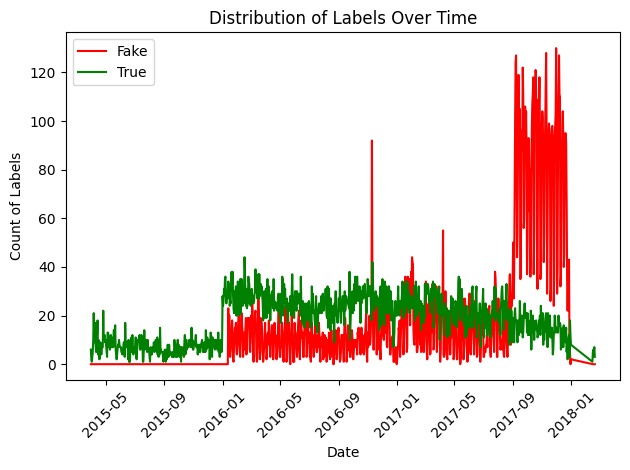

In [10]:
# observe timeseries for labels
df_time = pd.concat([X_train['date'], y_train, y_train], axis=1) # we need a third column for the groupby operation
df_time.columns = ['date', 'fake', 'true']
df_time['true']= df_time['true'].replace({1: 0, 0: 1})  # flip the labels for plotting
# group by date and count the number of occurrences of each label
df_time = df_time.groupby('date').sum().reset_index()

# plot the distribution of labels over time
sns.lineplot(data=df_time, x='date', y='fake', label='Fake', color='red')
sns.lineplot(data=df_time, x='date', y='true', label='True', color='green')
plt.title('Distribution of Labels Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Subject categories

In [15]:
# check text in subject columns
print('Subject types:')
print(X_train['subject'].value_counts())

Subject types:
subject
politicsNews       9037
worldnews          7932
News               7279
politics           5484
left-news          3554
Government News    1252
US_News             610
Middle-east         603
Name: count, dtype: int64


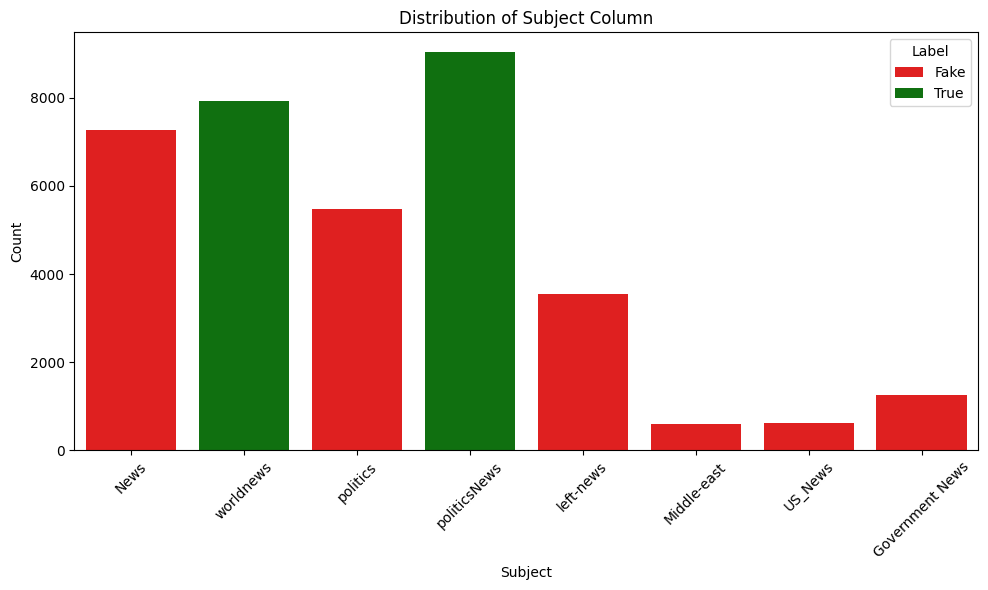

In [16]:
# create df for the subject column
df_subject = pd.concat([X_train['subject'], y_train], axis=1)
# rename the columns
df_subject.columns = ['subject', 'label']

# plot the distribution of the new subject column
plt.figure(figsize=(10, 6))
sns.countplot(data = df_subject ,x='subject', hue = 'label', palette=['red', 'green'])
plt.legend(title='Label', loc='upper right', labels=['Fake', 'True'])
plt.title('Distribution of Subject Column')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Note: the subject is essentially a proxy for the the target so should not be used as a feature

### Text analysis

#### Text processing

In [31]:
# some preprocessing steps
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    # remove punctuation and special characters
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    # nltk tasks
    # tokenize the text
    tokens = word_tokenize(text)
    # remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # join the tokens back into a string
    text = ' '.join(tokens)
    return text

# apply the preprocessing function to the text column
X_train['text'] = X_train['text'].apply(preprocess_text)

#### Word Cloud

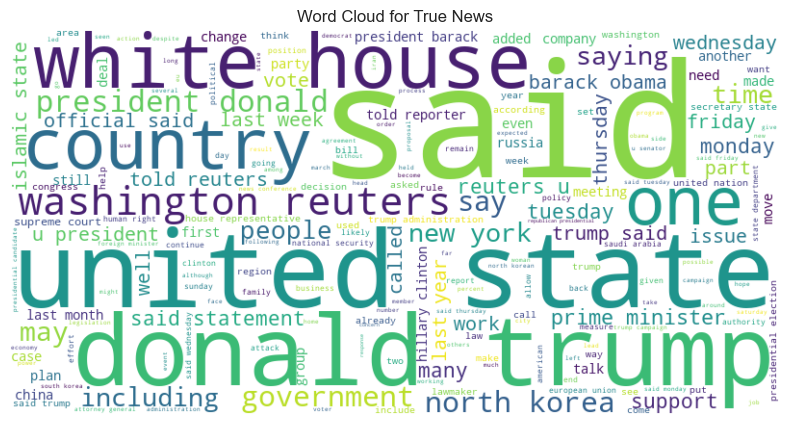

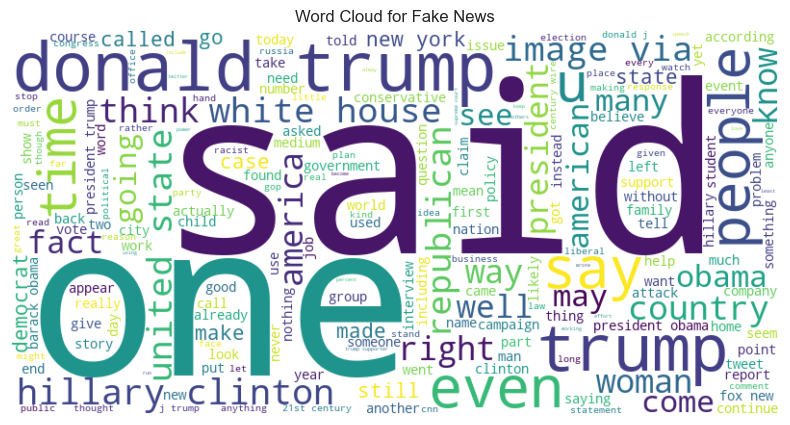

In [ ]:
# generate word clouds for real and fake news
def generate_wordcloud(text, title=None):
    wordcloud = WordCloud(
        width = 800,
        height = 400,
        background_color = 'white',
        stopwords = STOPWORDS,
        colormap ='viridis'
    ).generate(text)

    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()
    
# combine all text from the 'text' column and group by label in y_train
text_true = ' '.join(X_train[y_train == 1]['text'])
text_fake = ' '.join(X_train[y_train == 0]['text']) 
    
# generate word cloud for the 'text' column
generate_wordcloud(text_true, title = 'Word Cloud for True News')
print()
generate_wordcloud(text_fake, title = 'Word Cloud for Fake News')

## Baseline classifier

In [18]:
# create an embedding of the text using TF-IDF
vectorizer = TfidfVectorizer(max_features = 1000)  # limit to 1000 features for simplicity    
X_train_vec = vectorizer.fit_transform(X_train['text'])
# convert the sparse matrix to a dense matrix
X_train_vec = X_train_vec.toarray()

In [ ]:
# create and train a logistic regression model as a baseline
clf = LogisticRegression(max_iter = 1000, random_state = 42)

# fit the model
clf.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# apply the same preprocessing to the test set
X_test['text'] = X_test['text'].apply(preprocess_text)
X_test_vec = vectorizer.transform(X_test['text'])
# convert the sparse matrix to a dense matrix
X_test_vec = X_test_vec.toarray()

Accuracy of the baseline model: 0.9851
Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      4696
        True       0.98      0.99      0.98      4242

    accuracy                           0.99      8938
   macro avg       0.98      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



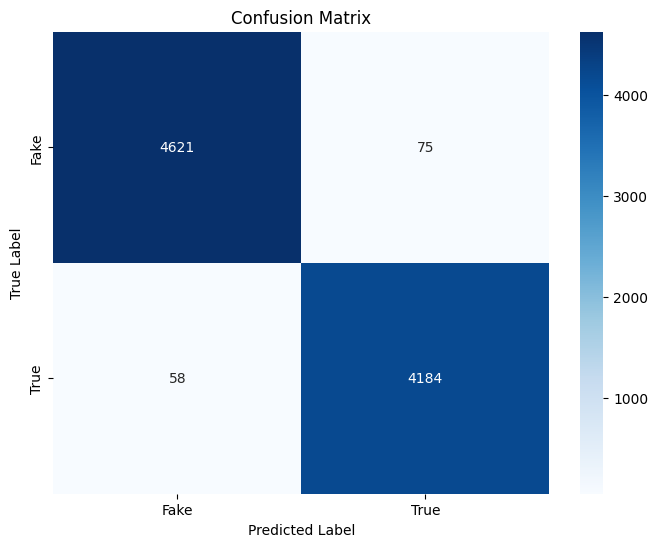

In [22]:
# make predictions on the test set
prediction = clf.predict(X_test_vec)
accuracy = accuracy_score(y_test,prediction)
print(f"Accuracy of the baseline model: {accuracy:.4f}")

# print the classification report
print("Classification Report:")
print(classification_report(y_test, prediction, target_names=['Fake', 'True']))

# plot the confusion matrix
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Improvements

### Grid search with logistic regression

Note: I would have tried XGBoost instead of Random Forest, but had an issue with my current environment and didn't want to to restart

In [24]:
# create a pipeline for the logistic regression model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter = 1000))
])

# parameter tuning using GridSearchCV
param_grid = {
    # for the TfidfVectorizer
    'tfidf__ngram_range': [(1,1), (1,2)], # use unigrams or unigrams + bigrams

    # for the Logistic Regression classifier
    'clf__C': [0.1, 1, 10], # regularization strength
    'clf__penalty': ['l2'], # regularization type
    'clf__solver': ['liblinear'] # optimizer
}

# create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring='accuracy', verbose = 2)

# fit the grid search to the training data
grid_search.fit(X_train["text"], y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-val accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 1); total time=   9.3s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 1); total time=  13.1s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 1); total time=  11.9s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 1); total time=  11.6s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 1); total time=  14.3s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 2); total time=  56.0s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 2); total time=  41.1s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 2); total time=  52.1s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, tfidf__ngram_range=(1, 

In [25]:
# select the best model from the grid search
best_model = grid_search.best_estimator_

# inspect coefficients of the best model
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
coefficients = best_model.named_steps['clf'].coef_[0]
# create a DataFrame to hold the feature names and their coefficients
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
# sort the DataFrame by the absolute value of the coefficients
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()   
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)
# print the top 10 features with the highest absolute coefficients
print("Top 10 features with the highest absolute coefficients:")
print(coef_df[['feature', 'coefficient']].head(10))

Top 10 features with the highest absolute coefficients:
           feature  coefficient
148772     reuters    59.632714
152607        said    30.410975
184478         via   -17.553239
87308        image   -12.975611
187085  washington    10.266370
74298          gop    -9.756130
188099   wednesday     9.667021
56324         dont     9.350313
179017     tuesday     9.031882
121582       obama    -8.776127


/var/folders/f0/5ds76gxs38s75310kkpp75b00000gn/T/ipykernel_82503/3509523890.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fake_coef.head(10), x='coefficient', y='feature', palette='Reds')


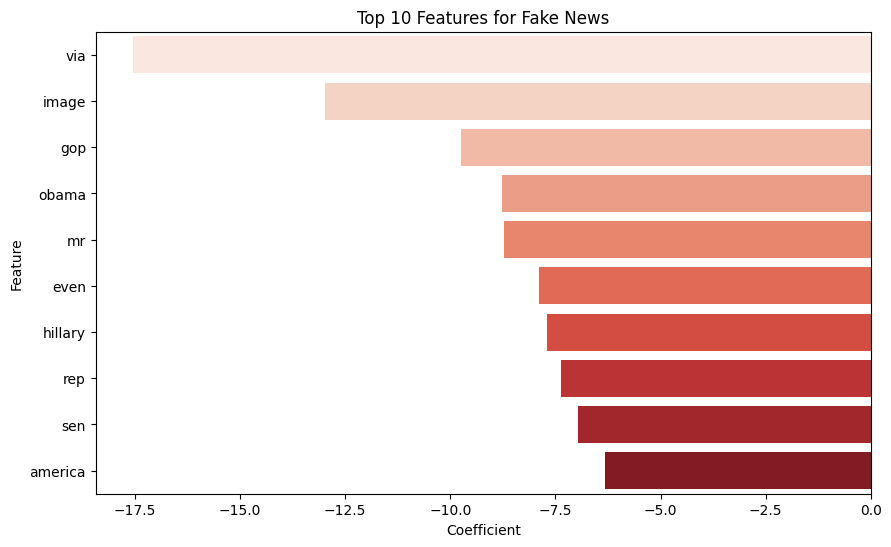

/var/folders/f0/5ds76gxs38s75310kkpp75b00000gn/T/ipykernel_82503/3509523890.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=true_coef.head(10), x='coefficient', y='feature', palette='Greens')


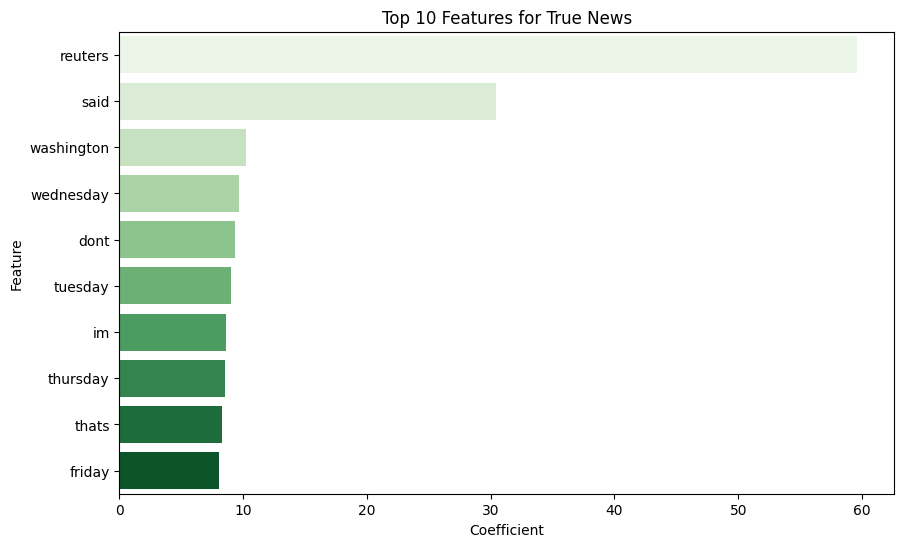

In [27]:
# split the model analysis into two parts: fake and true news
fake_coef = coef_df[coef_df['coefficient'] < 0]
true_coef = coef_df[coef_df['coefficient'] > 0]
# plot the top 10 features for fake news
plt.figure(figsize=(10, 6))
sns.barplot(data=fake_coef.head(10), x='coefficient', y='feature', palette='Reds')
plt.title('Top 10 Features for Fake News')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

# plot the top 10 features for true news
plt.figure(figsize=(10, 6)) 
sns.barplot(data=true_coef.head(10), x='coefficient', y='feature', palette='Greens')
plt.title('Top 10 Features for True News')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()


Accuracy of the best model: 0.9938
Classification Report for the Best Model:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        True       0.99      0.99      0.99      4242

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



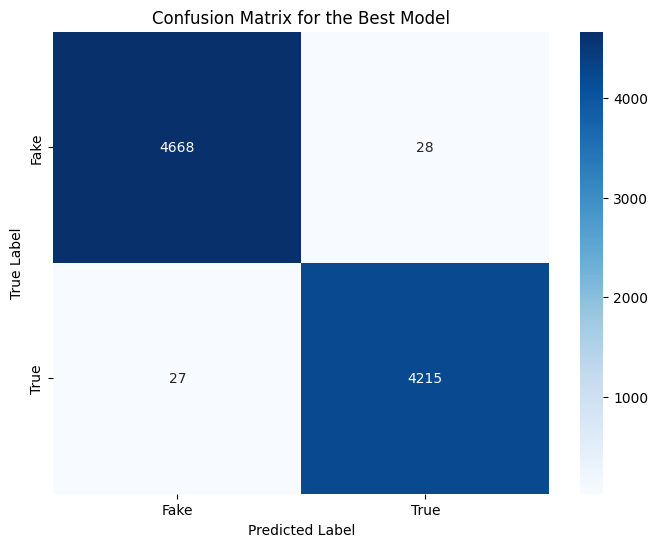

In [ ]:
# make predictions on the test set using the best model
prediction_best = best_model.predict(X_test["text"])

# calculate accuracy of the best model
accuracy_best = accuracy_score(y_test, prediction_best)
print(f"Accuracy of the best model: {accuracy_best:.4f}")

# print the classification report for the best model
print("Classification Report for the Best Model:")
print(classification_report(y_test, prediction_best, target_names=['Fake', 'True']))

# plot the confusion matrix for the best model
cm_best = confusion_matrix(y_test, prediction_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix for the Best Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()